# CS818 Assessment: notebook 2
I now have a good overview of the data and the basic demographic features included. I can go further and perform multivariate analysis to better understand the remaining variables.

In [1]:
# Import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

# Set up matplotlib integration 
%matplotlib inline

First, I want to assess correlation between the numeric variables. I can incorporate obesity rates in the form of BMI, which first needs creating as a variable. 

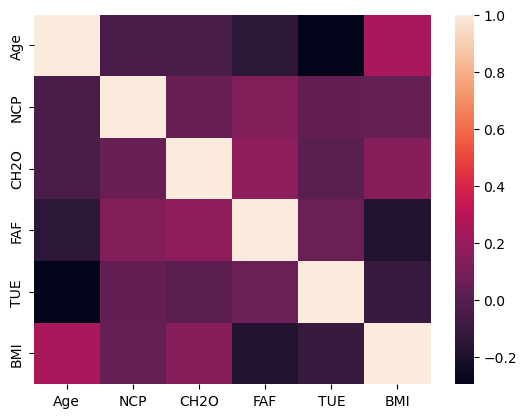

In [2]:
# Create BMI variable
df["BMI"] = df["Weight"] / (df["Height"] ** 2)

df_corr = df.drop(["Weight", "Height", "FCVC"], axis=1)

# Isolate numeric variables, then calculate correlations and display in a heatmap
corr = df_corr.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr)
plt.savefig("numeric_correlations.pdf")
plt.show()

Restacking the 'corr' file can help illustrate the strongest correlations.

In [3]:
# Unstack the correlation matrix and filter out the instances of a variable correlating with itself
corr_pairs = corr.unstack()
corr_pairs = corr_pairs[corr_pairs.abs() != 1]

# Convert to a dataframe so I can print the data as a Latex table 
corr_df = corr_pairs.reset_index()
corr_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Remove duplicate pairs (i.e. currently we have Age vs TUE and then TUE vs Age immediately after)
corr_df = corr_df[corr_df['Variable 1'] < corr_df['Variable 2']]

# Sort by largest absolute value, to ensure both negative and positive correlations factored in, and list the top 10
corr_df = corr_df.reindex(corr_df.Correlation.abs().sort_values(ascending=False).index).head(10)
print(corr_df)

# Generate the Latex table

latex_table = corr_df.to_latex(index=False,
                               float_format="%.3f",
                               caption="Top 10 Strongest Correlation Pairs",
                               label="tab:top_correlations",
                               longtable=False,
                               escape=False)
print(latex_table)

   Variable 1 Variable 2  Correlation
3         Age        TUE    -0.296931
4         Age        BMI     0.244163
28        BMI        FAF    -0.177537
12       CH2O        FAF     0.167236
2         Age        FAF    -0.144938
27        BMI       CH2O     0.144200
16        FAF        NCP     0.129504
29        BMI        TUE    -0.099720
18        FAF        TUE     0.058562
11       CH2O        NCP     0.057088
\begin{table}
\caption{Top 10 Strongest Correlation Pairs}
\label{tab:top_correlations}
\begin{tabular}{llr}
\toprule
Variable 1 & Variable 2 & Correlation \\
\midrule
Age & TUE & -0.297 \\
Age & BMI & 0.244 \\
BMI & FAF & -0.178 \\
CH2O & FAF & 0.167 \\
Age & FAF & -0.145 \\
BMI & CH2O & 0.144 \\
FAF & NCP & 0.130 \\
BMI & TUE & -0.100 \\
FAF & TUE & 0.059 \\
CH2O & NCP & 0.057 \\
\bottomrule
\end{tabular}
\end{table}



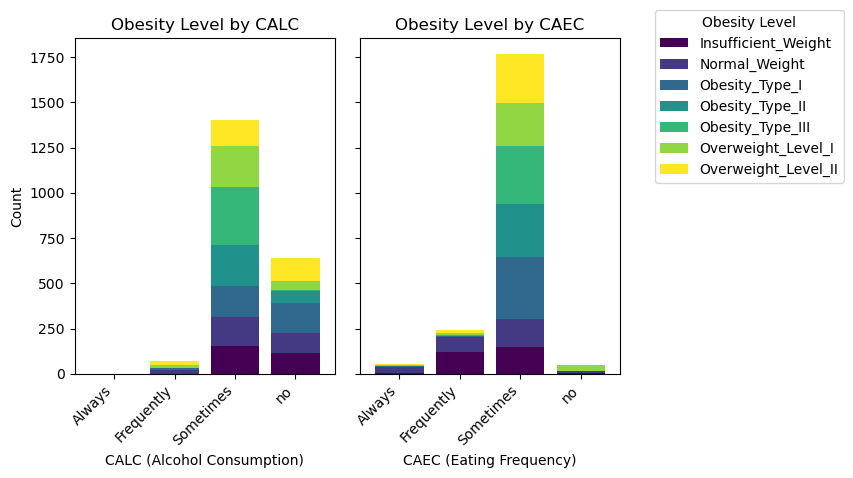

In [4]:
# Create subplots for stacked bar charts
fig, axes = plt.subplots(1, 2, sharey=True)

# Compute cross-tabulation for CALC and CAEC against NObeyesdad
calc = df.groupby(["CALC", "NObeyesdad"]).size().unstack()
caec = df.groupby(["CAEC", "NObeyesdad"]).size().unstack()

# Plot stacked bar chart for CALC (Alcohol Consumption)
calc.plot(kind="bar", stacked=True, ax=axes[0], colormap="viridis", width=0.8, legend=False)
axes[0].set_title("Obesity Level by CALC")
axes[0].set_xlabel("CALC (Alcohol Consumption)")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

# Plot stacked bar chart for CAEC (Eating Frequency)
caec.plot(kind="bar", stacked=True, ax=axes[1], colormap="viridis", width=0.8, legend=False)
axes[1].set_title("Obesity Level by CAEC")
axes[1].set_xlabel("CAEC (Eating Frequency)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Add a single legend outside the plot for both of them
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Obesity Level", bbox_to_anchor=(1.02, 1), loc="upper left")

# Improve layout
plt.tight_layout()
plt.savefig("CALC_and_CAEC.pdf")
plt.show()

We can consider the binary variables and their relationship to obesity by first setting up obesity as a binary variable.

In [5]:
# Create a binary variable, whereby a BMI of 30+ is obese and anything below is not obese (in line with WHO definitions)
obesity_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 0,
    'Overweight_Level_I': 0,
    'Overweight_Level_II': 0,
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1
}

# Add this variable to the dataset
df['obesity_binary'] = df['NObeyesdad'].map(obesity_mapping)

# Now create a dataset for the binary variables (plus Gender, which is a categorical variable but only has 2 options in this dataset) which establishes numbers of obese vs non-obese individuals in each category.
obesity_rates = []

for col in ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'Gender']:
    obesity_rate_series = df.groupby(col)['obesity_binary'].mean()

    # Establish an obese and a non-obese rate
    for category, obesity_rate in obesity_rate_series.items():
        obesity_rates.append({'Variable': col, 'Category': category, 'Obesity Status': 'Obese', 'Obesity Rate': obesity_rate})
        obesity_rates.append({'Variable': col, 'Category': category, 'Obesity Status': 'Not obese', 'Obesity Rate': 1 - obesity_rate})

obesity_rates_df = pd.DataFrame(obesity_rates)
obesity_rates_df

,Variable,Category,Obesity Status,Obesity Rate
0,family_history_with_overweight,no,Obese,0.020779
1,family_history_with_overweight,no,Not obese,0.979221
2,family_history_with_overweight,yes,Obese,0.558517
3,family_history_with_overweight,yes,Not obese,0.441483
4,FAVC,no,Obese,0.077551
5,FAVC,no,Not obese,0.922449
6,FAVC,yes,Obese,0.510718
7,FAVC,yes,Not obese,0.489282
8,SMOKE,no,Obese,0.459603
9,SMOKE,no,Not obese,0.540397


Now I can visualise these:

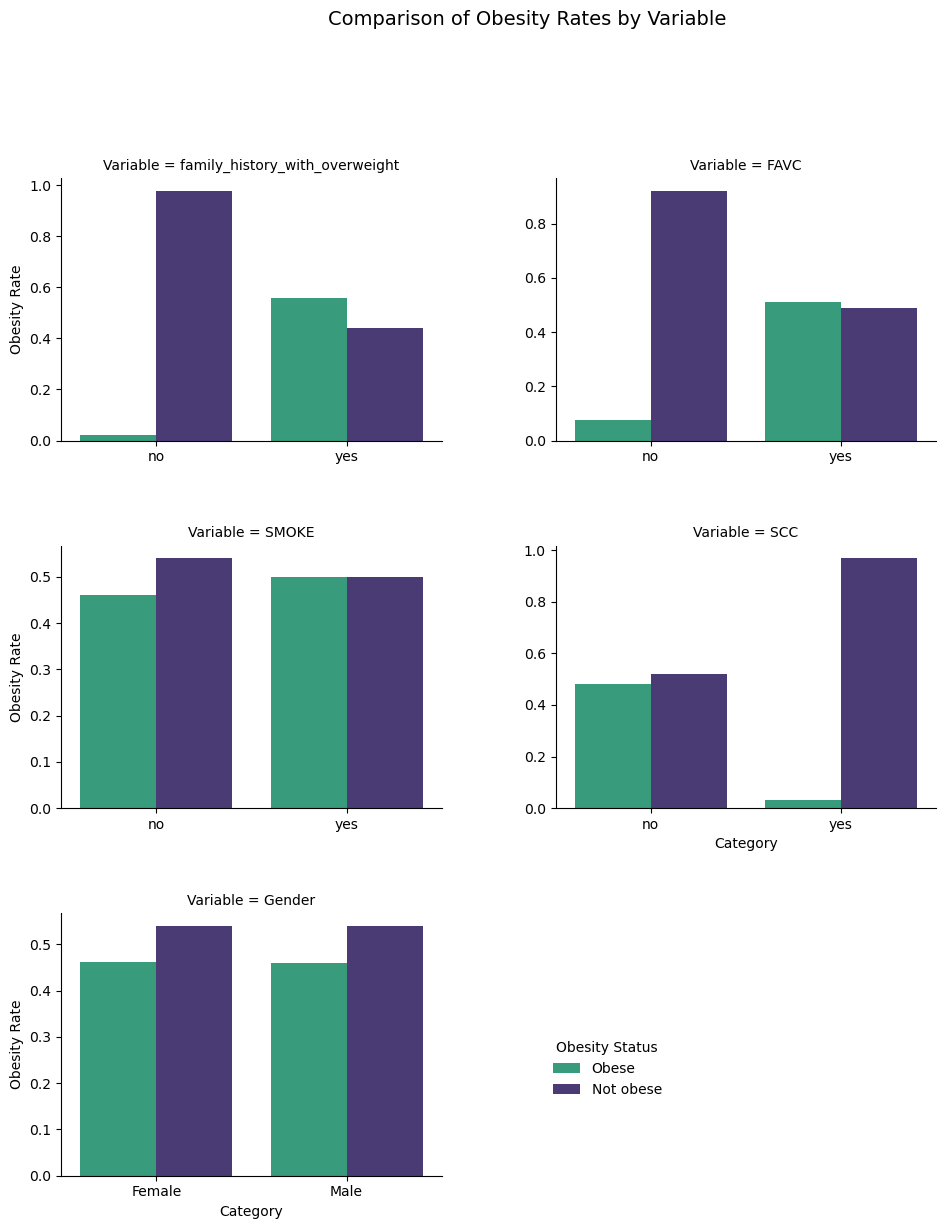

In [6]:
# Color palette, matching up with viridis (an accessible palette) used elsewhere in the assessment
custom_palette = ["#27AC81", "#46327E"]

# Define category orders for each variable to get the x axis labels working properly 
category_orders = {
    "family_history_with_overweight": ["no", "yes"],
    "FAVC": ["no", "yes"],
    "SMOKE": ["no", "yes"],
    "SCC": ["no", "yes"],
    "Gender": ["Male", "Female"]
}

# Create plot, grouping together so that the graphs are easier to interpret 
g = sns.catplot(
    data=obesity_rates_df,
    x="Category",      
    y="Obesity Rate",
    hue="Obesity Status",
    col="Variable",  
    kind="bar",
    col_wrap=2,            
    sharex=False,       
    sharey=False,      
    height=4,
    aspect=1.2,
    palette=custom_palette, 
    order=None             
)

g.set_axis_labels("Category", "Obesity Rate")
g.fig.suptitle("Comparison of Obesity Rates by Variable", fontsize=14, y=1.02)
g.fig.subplots_adjust(top=0.88, wspace=0.3, hspace=0.4)

g._legend.set_loc("lower left")
g._legend.set_bbox_to_anchor((0.5, 0.1))
plt.savefig("binary_obesity.pdf")
plt.show()

The final category to consider is the mode of transport individuals generally use. 

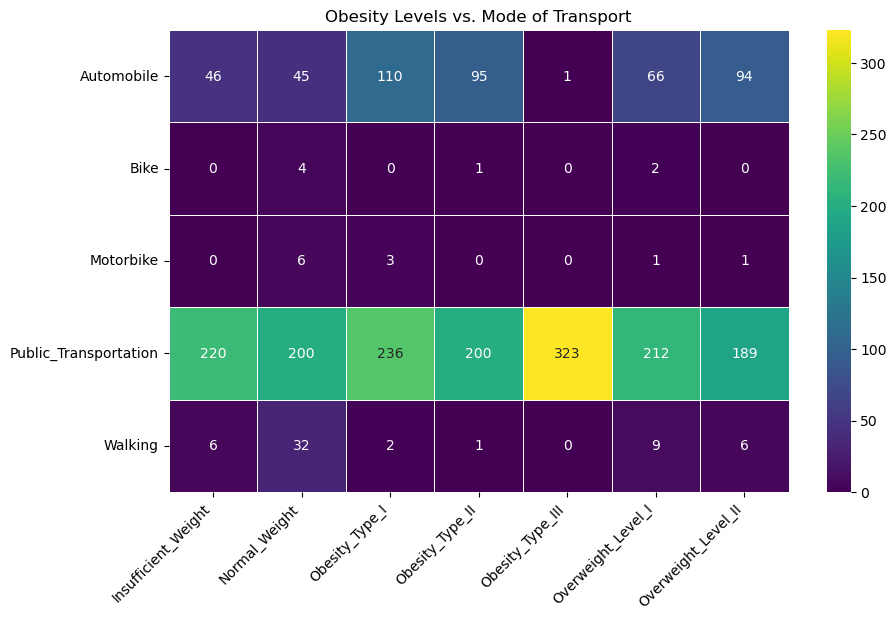

In [7]:
# First create a cross-tabulation table to show the relationship between the categorical variables of obesity level and mode of transport
mtrans_heatmap = pd.crosstab(df["MTRANS"], df["NObeyesdad"])

# Plot as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mtrans_heatmap, annot=True, cmap="viridis", fmt="d", linewidths=0.5)

plt.title("Obesity Levels vs. Mode of Transport")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45, ha="right")
plt.savefig("MTRANS_heatmap.pdf", bbox_inches="tight")
plt.show()